In [1]:
import sys, os, io, random, json, re
import pandas as pd
from collections import Counter
from time_helpers import *

%matplotlib inline

In [2]:
def find_exact_string(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

In [3]:
def load_json(fn):
    ret = None
    with io.open(fn, "r", encoding="utf-8") as f:
        ret = json.load(f)
    return ret

In [18]:
def save_json(fn, d):
    with io.open(fn, "w", encoding="utf-8") as f:
        f.write(json.dumps(d, indent=4))

In [4]:
stopwords = load_json("config/stopwords.json")
stopwords = stopwords["en"]
stopwords += ["rt", "-", "&amp;"]

def tokenize_sentence(text):
    words = re.split(r'(\s+)', text)
    if len(words) < 1:
        return
    tokens = []
    for w in words:
        if w is not None:
            w = w.strip()
            w = w.lower()
            if w.isspace() or w == "\n" or w == "\r":
                w = None
            if w is not None and "http" in w:
                w = None
            if w is not None and len(w) < 1:
                w = None
            if w is not None and u"…" in w:
                w = None
            if w is not None:
                tokens.append(w)
    if len(tokens) < 1:
        return []
# Remove stopwords and other undesirable tokens
    cleaned = []
    for token in tokens:
        if len(token) > 0:
            if stopwords is not None:
                if token in stopwords:
                    token = None
            if token is not None:
                if re.search(".+…$", token):
                    token = None
            if token is not None:
                if token == "#":
                    token = None
            if token is not None:
                if token[-1] == ".":
                    token = token[:-1]
            if token is not None:
                cleaned.append(token)
    if len(cleaned) < 1:
        return []
    return cleaned

In [5]:
def save_csv(inter, fn):
    with io.open(fn, "w", encoding="utf-8") as f:
        f.write("Source,Target,Weight\n")
        for source, targets in inter.items():
            for target, count in targets.items():
                f.write(source + "," + target + "," + str(count) + "\n")

In [6]:
def print_hashtag_trends(hashtags):
    timestamps = {}
    for h in hashtags:
        timestamps[h] = {}
    count = 0
    with io.open("data/raw.json", "r", encoding="utf-8") as f:
        for line in f:
            count += 1
            if count % 10000 == 0:
                print("Count: " + str(count))
            d = json.loads(line)
            if "hashtags" in d:
                ht = d["hashtags"]
                for h in hashtags:
                    if h in ht:
                        tobj = twitter_time_to_readable(d["created_at"])
                        thour = tobj[:-3]
                        if thour not in timestamps[h]:
                            timestamps[h][thour] = 1
                        else:
                            timestamps[h][thour] += 1
    df = None
    if len(hashtags) > 1:
        df = pd.DataFrame(timestamps)
    else:
        df = pd.Series(timestamps)
    df = df.interpolate()
    df.plot(figsize=(20,10))

In [30]:
def get_retweets_for_sns(sn_list):
    retweeted = []
    with io.open("data/raw.json", "r", encoding="utf-8") as f:
        count = 0
        for line in f:
            count += 1
            if count % 10000 == 0:
                print("Count: " + str(count))
            d = json.loads(line)
            sn = d["user"]["screen_name"]
            if sn in sn_list:
                if "retweeted_status" in d:
                    retweeted_sn = d["retweeted_status"]["user"]["screen_name"]
                    if retweeted_sn not in retweeted:
                        retweeted.append(retweeted_sn)
    return retweeted

In [7]:
def print_user_trends(users):
    timestamps = {}
    for u in users:
        timestamps[u] = {}
    count = 0
    with io.open("data/raw.json", "r", encoding="utf-8") as f:
        for line in f:
            count += 1
            if count % 10000 == 0:
                print("Count: " + str(count))
            d = json.loads(line)
            if "user" in d and "screen_name" in d["user"]:
                sn = d["user"]["screen_name"]
                for u in users:
                    if u == sn:
                        tobj = twitter_time_to_readable(d["created_at"])
                        thour = tobj[:-3]
                        if thour not in timestamps[u]:
                            timestamps[u][thour] = 1
                        else:
                            timestamps[u][thour] += 1
    df = None
    if len(users) > 1:
        df = pd.DataFrame(timestamps)
    else:
        df = pd.Series(timestamps)
    df = df.interpolate()
    df.plot(figsize=(20,10))

In [22]:
def match_graph(inter, match_list):
    ret = {}
    for source, targets in inter.items():
        if source in match_list:
            ret[source] = targets
            continue
        for target, weight in targets.items():
            if target in match_list:
                ret[source] = targets
                break
    return ret

In [33]:
def match_graph2(inter, match_list):
    ret = {}
    for source, targets in inter.items():
        if source in match_list:
            for target, weight in targets.items():
                if target in match_list:
                    if source not in ret:
                        ret[source] = {}
                    ret[source][target] = weight
    return ret

In [37]:
def trim_graph(inter, all_users, cutoff):
    print("All users: " + str(len(all_users)))
    trimmed_users = []
    for name, count in all_users.items():
        if count > cutoff:
            trimmed_users.append(name)
    print("Trimmed users: " + str(len(trimmed_users)))
    trimmed = {}
    for source, targets in inter.items():
        if source in trimmed_users:
            trimmed[source] = targets
            continue
        found = False
        for target, count in targets.items():
            if target in trimmed_users:
                trimmed[source] = targets
                break
    return trimmed

In [38]:
def trim_graph2(inter, all_users, cutoff):
    print("All users: " + str(len(all_users)))
    trimmed_users = []
    for name, count in all_users.items():
        if count > cutoff:
            trimmed_users.append(name)
    print("Trimmed users: " + str(len(trimmed_users)))
    trimmed = {}
    for source, targets in inter.items():
        if source in trimmed_users:
            for target, count in targets.items():
                if target in trimmed_users:
                    if source not in trimmed:
                        trimmed[source] = {}
                    trimmed[source][target] = count
            continue
        found = False
        for target, count in targets.items():
            if target in trimmed_users:
                if source not in trimmed:
                    trimmed[source] = {}
                trimmed[source][target] = count
    return trimmed

In [8]:
with io.open("data/raw.json", "r", encoding="utf-8") as f:
    for line in f:
        d = json.loads(line)
        print(json.dumps(d, indent=4))
        break

{
    "lang": "en",
    "quote_count": 0,
    "interactions": [
        "citysamuel"
    ],
    "text": "The EU's reckless desire for revenge on the UK overrides their duty to protect the people of Europe. The #Brexit ne\u2026 https://t.co/QeodZLnAtz",
    "created_at": "Mon Dec 03 12:07:15 +0000 2018",
    "hashtags": [
        "brexit"
    ],
    "retweeted": null,
    "is_quote_status": true,
    "in_reply_to_status_id": null,
    "reply_count": 0,
    "in_reply_to_screen_name": null,
    "id_str": "1069563714406412294",
    "urls": [
        "https://twitter.com/i/web/status/1069563714406412294"
    ],
    "retweet_count": 0,
    "user": {
        "default_profile": true,
        "statuses_count": 22756,
        "description": "Old friend of Charlie (of Charlie's Law). Blocked by the Guardian. Blocked by Strictly.",
        "verified": false,
        "followers_count": 102,
        "screen_name": "LawCharlies",
        "id_str": "877458106850127872",
        "default_profile_image"

In [20]:
highly_retweeted = []
highly_retweeted_ids = []
highly_liked = []
highly_liked_ids = []
highly_replied = []
highly_replied_ids = []
highly_retweeted_users = Counter()
highly_replied_to_users = Counter()
interactions = {}
counters = {}
magas = []
counter_names = ["users",
                 "influencers",
                 "amplifiers",
                 "hashtags",
                 "highly_retweeted_users",
                 "highly_replied_to_users",
                 "words",
                 "urls"]
user_fields = ["users",
               "influencers",
               "amplifiers",
               "highly_retweeted_users",
               "highly_replied_to_users"]
for n in counter_names:
    counters[n] = Counter()
min_retweet_count = 2000
min_like_count = 2000
min_replied_count = 1000
count = 0
with io.open("data/raw.json", "r", encoding="utf-8") as f:
    for line in f:
        count += 1
        if count % 10000 == 0:
            print("Count: " + str(count))
        d = json.loads(line)
        twid = d["id_str"]
        sn = d["user"]["screen_name"]
        counters["users"][sn] += 1
        text = d["text"]
        tokens = tokenize_sentence(text)
        for t in tokens:
            counters["words"][t] += 1
        if "in_reply_to_screen_name" in d and d["in_reply_to_screen_name"] is not None:
            counters["highly_replied_to_users"][d["in_reply_to_screen_name"]] += 1
        if "user" in d and "description" in d["user"]:
            desc = d["user"]["description"]
            if desc is not None:
                if find_exact_string("maga")(desc.lower()):
                    if sn not in magas:
                        magas.append(sn)
        if "hashtags" in d:
            ht = d["hashtags"]
            for h in ht:
                counters["hashtags"][h] += 1
        if "urls" in d:
            urls = d["urls"]
            for u in urls:
                if "twitter" not in u:
                    counters["urls"][u] += 1
        if "interactions" in d:
            counters["amplifiers"][sn] += 1
            inter = d["interactions"]
            if sn not in interactions:
                interactions[sn] = {}
            for i in inter:
                counters["influencers"][i] += 1
                if i not in interactions[sn]:
                    interactions[sn][i] = 1
                else:
                    interactions[sn][i] += 1
        if "reply_count" in d:
            if d["reply_count"] is not None and d["reply_count"] > min_replied_count:
                if twid not in highly_replied_ids:
                    highly_replied_ids.append(twid)
                    highly_replied.append(d)
        if "retweet_count" in d:
            if d["retweet_count"] is not None and d["retweet_count"] > min_retweet_count:
                if twid not in highly_retweeted_ids:
                    highly_retweeted_ids.append(twid)
                    highly_retweeted.append(d)
        if "favorite_count" in d:
            if d["favorite_count"] is not None and d["favorite_count"] > min_like_count:
                if twid not in highly_liked_ids:
                    highly_liked_ids.append(twid)
                    highly_liked.append(d)
        if "retweeted_status" in d:
            rtwid = d["retweeted_status"]["id_str"]
            retweeted_sn = d["retweeted_status"]["user"]["screen_name"]
            counters["highly_retweeted_users"][retweeted_sn] += 1
            s = d["retweeted_status"]
            if "retweet_count" in s:
                if s["retweet_count"] is not None and s["retweet_count"] > min_retweet_count:
                    if rtwid not in highly_retweeted_ids:
                        highly_retweeted_ids.append(rtwid)
                        highly_retweeted.append(s)
            if "favorite_count" in s:
                if s["favorite_count"] is not None and s["favorite_count"] > min_like_count:
                    if rtwid not in highly_liked_ids:
                        highly_liked_ids.append(rtwid)
                        highly_liked.append(s)
            if "reply_count" in s:
                if s["reply_count"] is not None and s["reply_count"] > min_replied_count:
                    if twid not in highly_replied_ids:
                        highly_replied_ids.append(twid)
                        highly_replied.append(s)
                    
                    
print("Processed " + str(count) + " tweets.")
print("Found " + str(len(counters["users"])) + " users.")
print("Highly retweeted: " + str(len(highly_retweeted)))
print("Highly liked: " + str(len(highly_liked)))
print("Highly replied to: " + str(len(highly_replied)))
for n in counter_names:
    print("")
    print(n)
    print("---------")
    for i, c in counters[n].most_common(20):
        if n in user_fields:
            i = "https://twitter.com/" + i
        if n == "hashtags":
            i = "https://twitter.com/search?q=%23" + i
        print(str(c) + "\t" + i)
save_csv(interactions, "data/interactions.csv")
print("")
print("Found " + str(len(magas)) + " magas.")
if len(magas) > 0:
    save_json("data/magas.json", magas)

Count: 10000
Count: 20000
Count: 30000
Count: 40000
Count: 50000
Count: 60000
Count: 70000
Count: 80000
Processed 89439 tweets.
Found 38541 users.
Highly retweeted: 92
Highly liked: 236
Highly replied to: 312

users
---------
119	https://twitter.com/esme_hornbeam
102	https://twitter.com/alistairpge
101	https://twitter.com/BrexitometerC
97	https://twitter.com/FBPETrundlelin
93	https://twitter.com/Simon19501
91	https://twitter.com/SheronWilkie
90	https://twitter.com/FAO_Scotbot
83	https://twitter.com/maelysdervenn
77	https://twitter.com/Ryan_HFW
73	https://twitter.com/EUVoteLeave23rd
73	https://twitter.com/VincentKevinHo4
72	https://twitter.com/madelineahind
71	https://twitter.com/Keithbird59Bird
69	https://twitter.com/jagxjr40
68	https://twitter.com/cloudcorporate
65	https://twitter.com/SpanishDan1
65	https://twitter.com/roblwilson
65	https://twitter.com/T_4_27
64	https://twitter.com/Doozy_45
63	https://twitter.com/tvThirdEyeB

influencers
---------
2708	https://twitter.com/femi_sorry
2

In [27]:
print("Trimming graph")
trimmed_graph = trim_graph(interactions, counters["users"], 10)
print("Saving csv")
save_csv(trimmed_graph, "data/trimmed_graph.csv")
print("Done")

Trimming graph
All users: 38541
Trimmed users: 1143
Saving csv
Done


In [21]:
maga_tweet_count = 0
for m in magas:
    if m in counters["users"]:
        maga_tweet_count += counters["users"][m]
print("Maga tweets: " + str(maga_tweet_count))

Maga tweets: 1018


In [24]:
maga_graph = match_graph(interactions, magas)
save_csv(maga_graph, "data/maga_graph.csv")
print("Done")

Done


In [34]:
maga_graph = match_graph2(interactions, magas)
save_csv(maga_graph, "data/maga_graph2.csv")
print("Done")

Done


In [31]:
maga_retweeted = get_retweets_for_sns(magas)
save_json("data/magas_retweeted.json", maga_retweeted)
print("Magas retweeted: " + str(len(maga_retweeted)) + " users.")

Count: 10000
Count: 20000
Count: 30000
Count: 40000
Count: 50000
Count: 60000
Count: 70000
Count: 80000
Count: 90000
Magas retweeted: 255 users.


In [32]:
maga_retweeted_graph = match_graph(interactions, maga_retweeted)
save_csv(maga_retweeted_graph, "data/maga_retweeted_graph.csv")
print("Done")

Done


In [10]:
interesting = ["brexitcentral",
               "Dr_H_F_Quinzel7",
               "Ryan_HFW",
               "VincentKevinHo4",
               "EUVoteLeave23rd",
               "captainbartlet3",
               "GreenOakFraming",
               "ljonesljones14",
               "philiprichards5",
               "PrancingHound",
               "AnEnglishRevolt"]

Count: 10000
Count: 20000
Count: 30000
Count: 40000
Count: 50000
Count: 60000
Count: 70000
Count: 80000


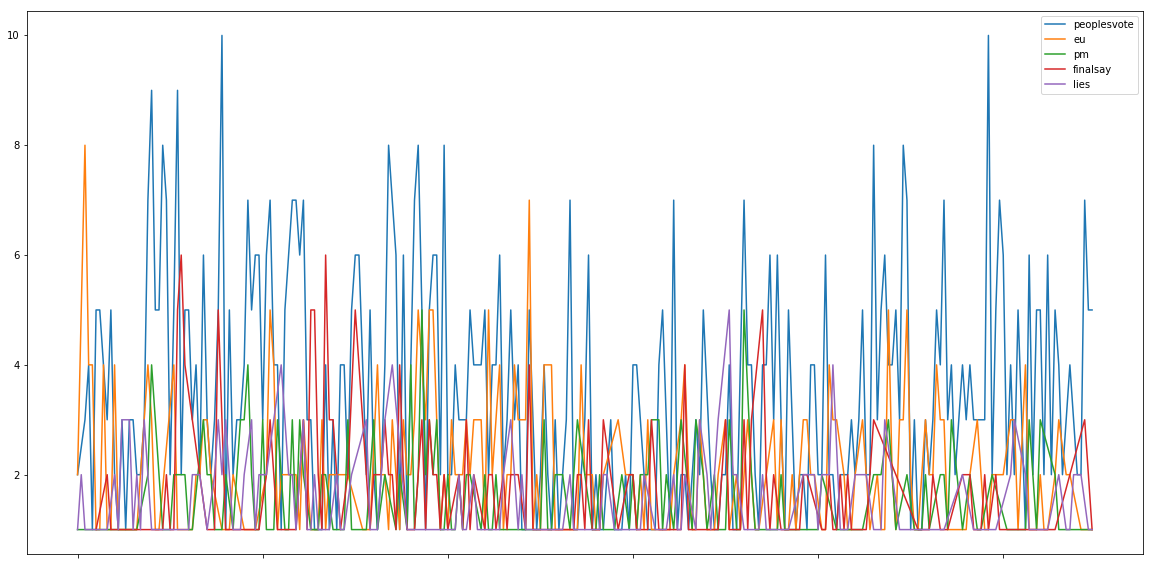

In [11]:
ht = [x for x, c in counters["hashtags"].most_common(6)][1:]
print_hashtag_trends(ht)

Count: 10000
Count: 20000
Count: 30000
Count: 40000
Count: 50000
Count: 60000
Count: 70000
Count: 80000


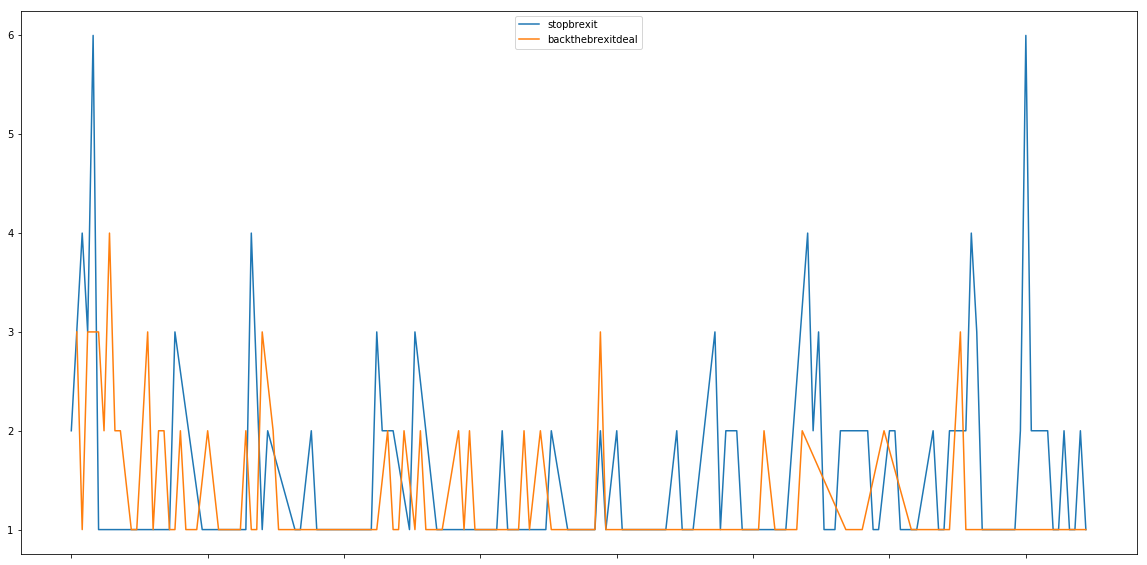

In [12]:
print_hashtag_trends(["stopbrexit", "backthebrexitdeal"])

Count: 10000
Count: 20000
Count: 30000
Count: 40000
Count: 50000
Count: 60000
Count: 70000
Count: 80000


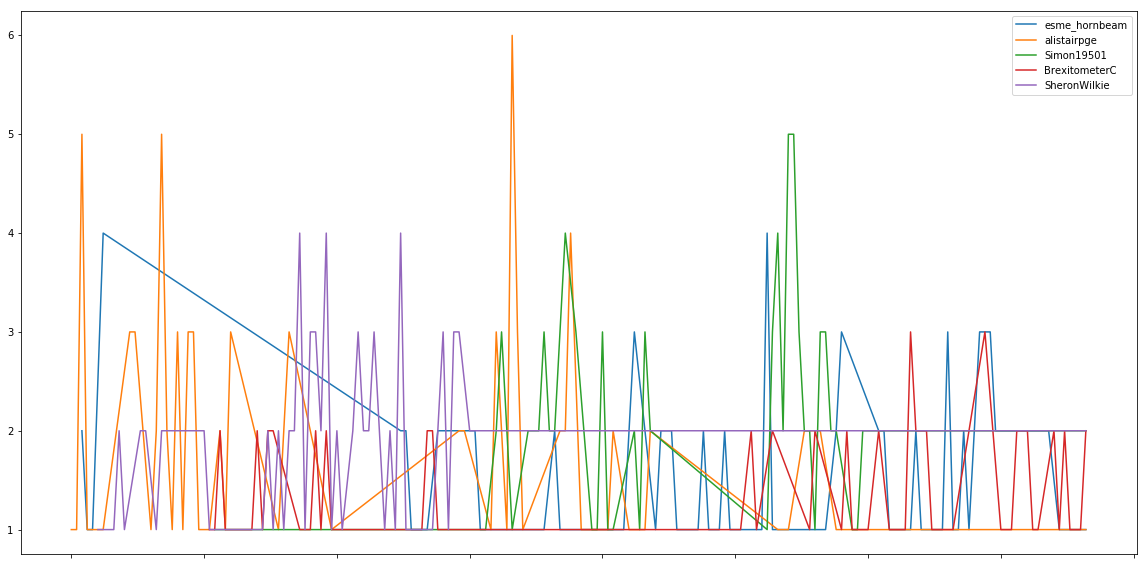

In [13]:
u = [x for x, c in counters["users"].most_common(5)]
print_user_trends(u)